In [1]:
#https://www.fao.org/faostat/en/#data
#Libraries
import pandas as pd
import numpy as np
from pathlib import Path #this library minimizes issues when using paths in Mac
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#pip freeze > requirements.txt

In [3]:
#Seaborn Context
sns.set_theme(style='whitegrid', context='talk', palette='deep')
#plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1));
#sns.set_palette(['#62C370', '#FFD166', '#EF476F'])# Plot
#plt.figure(figsize=(9, 5)) 

In [4]:
#List of Folders
prod_folder = Path("data/Value_of_Production_E_All_Data")
pop_folder = Path("data/Population_E_All_Data")

In [5]:
def clean_fao_df(df,element, drop_columns,value_column):
    #remove flags
    df = df[df.columns.drop(list(df.filter(regex='.*?F')))]
    #filter by element
    df = df[df["Element"]==element]
    #drop columns
    df = df[df.columns.drop(drop_columns)]
    #wide_to_long by year
    df=pd.wide_to_long(df, stubnames='Y', i=['Area', 'Item'], j='Year').reset_index()
    df.rename(columns = {'Y':value_column}, inplace = True)
    return df
    

In [6]:
prod_df = pd.read_csv(prod_folder /"Value_of_Production_E_All_Data.csv", encoding = 'unicode_escape')
prod_df.head()

,Area Code,Area Code (M49),Area,Item Code,Item Code (CPC),Item,Element Code,Element,Unit,Y1961,...,Y2016,Y2016F,Y2017,Y2017F,Y2018,Y2018F,Y2019,Y2019F,Y2020,Y2020F
0,2,'004,Afghanistan,221,'01371,"Almonds, in shell",152,Gross Production Value (constant 2014-2016 tho...,1000 Int. $,NaN,...,166057.0,E,137986.0,E,173995.0,E,193168.0,E,198739.0,E
1,2,'004,Afghanistan,221,'01371,"Almonds, in shell",56,Gross Production Value (current thousand SLC),1000 SLC,NaN,...,6539411.0,E,5213293.0,E,6239642.0,E,6707803.0,E,7160695.0,E
2,2,'004,Afghanistan,221,'01371,"Almonds, in shell",55,Gross Production Value (constant 2014-2016 tho...,1000 SLC,NaN,...,7004306.0,E,5820251.0,E,7339134.0,E,8147840.0,E,8382859.0,E
3,2,'004,Afghanistan,711,'01654,"Anise, badian, coriander, cumin, caraway, fenn...",152,Gross Production Value (constant 2014-2016 tho...,1000 Int. $,NaN,...,37675.0,E,41176.0,E,39326.0,E,39392.0,E,39965.0,E
4,2,'004,Afghanistan,515,'01341,Apples,152,Gross Production Value (constant 2014-2016 tho...,1000 Int. $,7127.0,...,66506.0,E,80449.0,E,102515.0,E,118153.0,E,127845.0,E


In [7]:
drop_columns = ["Area Code (M49)", "Area Code", "Item Code","Item Code (CPC)", "Element", "Element Code", "Unit"]
prod_df = clean_fao_df(prod_df, 'Gross Production Value (constant 2014-2016 thousand I$)', drop_columns, 'Total_Prod' )

In [8]:
#Chose 2019 as 2020 could be impacted by Covid
#https://www.nature.com/articles/s41599-022-01080-0
#The study concluded that interruptions in agricultural food supply as a result of the pandemic impacted supply and demand shocks with negative impacts on all the four pillars of food security.
prod_df=prod_df[prod_df["Year"]==2019]
prod_df = prod_df[prod_df.columns.drop(['Year'])]

In [9]:
pop_df = pd.read_csv(pop_folder /"Population_E_All_Data_NOFLAG.csv", encoding = 'unicode_escape')

In [10]:
drop_columns = ["Area Code (M49)", "Area Code", "Item Code", "Element", "Element Code", "Unit"]
pop_df = clean_fao_df(pop_df, 'Total Population - Both sexes', drop_columns, 'Total_Population' )
pop_df=pop_df[pop_df["Year"]==2019]
pop_df = pop_df[pop_df.columns.drop(['Item', 'Year'])]
pop_df.head()

,Area,Total_Population
69,Afghanistan,37769.499
220,Albania,2873.883
371,Algeria,42705.368
522,American Samoa,47.321
673,Andorra,76.343


In [11]:
prod_df=prod_df.merge(pop_df, how='left', on='Area') 

In [12]:
prod_df['Prod_Capita']=prod_df['Total_Prod']/prod_df['Total_Population']
prod_df = prod_df[prod_df.columns.drop(['Total_Prod', 'Total_Population'])]

In [13]:
prod_df.head()

,Area,Item,Prod_Capita
0,Afghanistan,"Almonds, in shell",5.114391
1,Afghanistan,"Anise, badian, coriander, cumin, caraway, fenn...",1.042958
2,Afghanistan,Apples,3.128265
3,Afghanistan,Apricots,2.805306
4,Afghanistan,Barley,0.637446


In [14]:
prod_df=prod_df.pivot(index='Area', columns='Item', values='Prod_Capita')

In [15]:
prod_df=prod_df.reset_index(level=0)

In [16]:
#Noticed that there are Areas that are not countries, but groups of them ("World", "Americas", etc.)
#Downloaded the groups file to remove them at once
pop_group_df = pd.read_csv(pop_folder /"Population_E_All_Area_Groups_NOFLAG.csv", encoding = 'unicode_escape')

In [17]:
prod_df = prod_df[~prod_df['Area'].isin(pop_group_df['Area'].unique())] 

In [18]:
prod_df.head()

Item,Area,"Abaca, manila hemp, raw","Agave fibres, raw, n.e.c.",Agriculture,"Almonds, in shell","Anise, badian, coriander, cumin, caraway, fennel and juniper berries, raw",Apples,Apricots,Areca nuts,Artichokes,...,Unmanufactured tobacco,"Vanilla, raw",Vegetables Primary,Vegetables and Fruit Primary,Vetches,"Walnuts, in shell",Watermelons,Wheat,Yams,Yautia
0,Afghanistan,NaN,NaN,174.078401,5.114391,1.042958,3.128265,2.805306,NaN,NaN,...,NaN,NaN,12.133944,62.010804,NaN,1.22771,5.202902,30.662361,NaN,NaN
2,Albania,NaN,NaN,736.821228,NaN,NaN,17.398412,1.389409,NaN,NaN,...,1.093294,NaN,151.655095,307.200398,0.251924,NaN,20.965711,19.218945,NaN,NaN
3,Algeria,NaN,NaN,364.737754,8.573185,NaN,6.176483,4.012376,NaN,1.941981,...,0.795263,NaN,73.969390,159.457167,0.000679,NaN,11.989523,21.499944,NaN,NaN
5,Angola,NaN,NaN,190.689824,NaN,NaN,NaN,NaN,NaN,NaN,...,0.201152,NaN,6.316054,63.896623,NaN,NaN,NaN,0.021667,NaN,NaN
6,Antigua and Barbuda,NaN,NaN,92.230533,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,6.622013,64.928298,NaN,NaN,NaN,NaN,0.390807,NaN


In [19]:
cols=['Area','Cereals, Total','Fruit Primary',
                                    'Meat indigenous, total','Milk, Total',
                                    'Non Food','Roots and Tubers, Total',
                                    'Sugar Crops Primary','Vegetables Primary']
prod_df=prod_df[cols]

In [20]:
print("There are",prod_df.shape[1]-1, "products and", prod_df.shape[0], "countries.\n")
print("The Products with most null values are:")
print(prod_df.isnull().sum().sort_values(ascending=False).head(5).to_string())


There are 8 products and 211 countries.

The Products with most null values are:
Item
Sugar Crops Primary    77
Non Food               36
Cereals, Total         31
Milk, Total            24
Vegetables Primary     16


In [21]:
#Drop values with 
prod_df.dropna(thresh=(prod_df.shape[1]+1)/2, inplace=True)

In [22]:
#Check: 
#print(prod_df.isna().sum(axis=1).sort_values(ascending=False).head(20).to_string())

In [23]:
prod_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Item,,,,,,,,
"Cereals, Total",180.0,77.019542,97.848773,0.002793,11.489062,39.850869,94.290468,415.269755
Fruit Primary,194.0,60.153664,68.857705,0.000341,15.475891,38.262886,77.354095,498.016533
"Meat indigenous, total",195.0,116.362872,147.878527,1.027024,32.067347,72.294603,138.024087,1143.134127
"Milk, Total",187.0,67.643678,154.882531,0.003335,6.713263,24.719916,89.946427,1828.248606
Non Food,175.0,11.186390,23.153876,0.011473,1.034110,4.444478,10.504840,230.533608
"Roots and Tubers, Total",194.0,28.114953,51.481350,0.000511,5.653638,14.179483,30.016120,581.988548
Sugar Crops Primary,134.0,16.066358,33.464111,0.001862,1.079345,5.499088,14.819981,220.159147
Vegetables Primary,194.0,31.180197,33.792774,0.323232,9.480679,17.115678,40.076852,176.513701


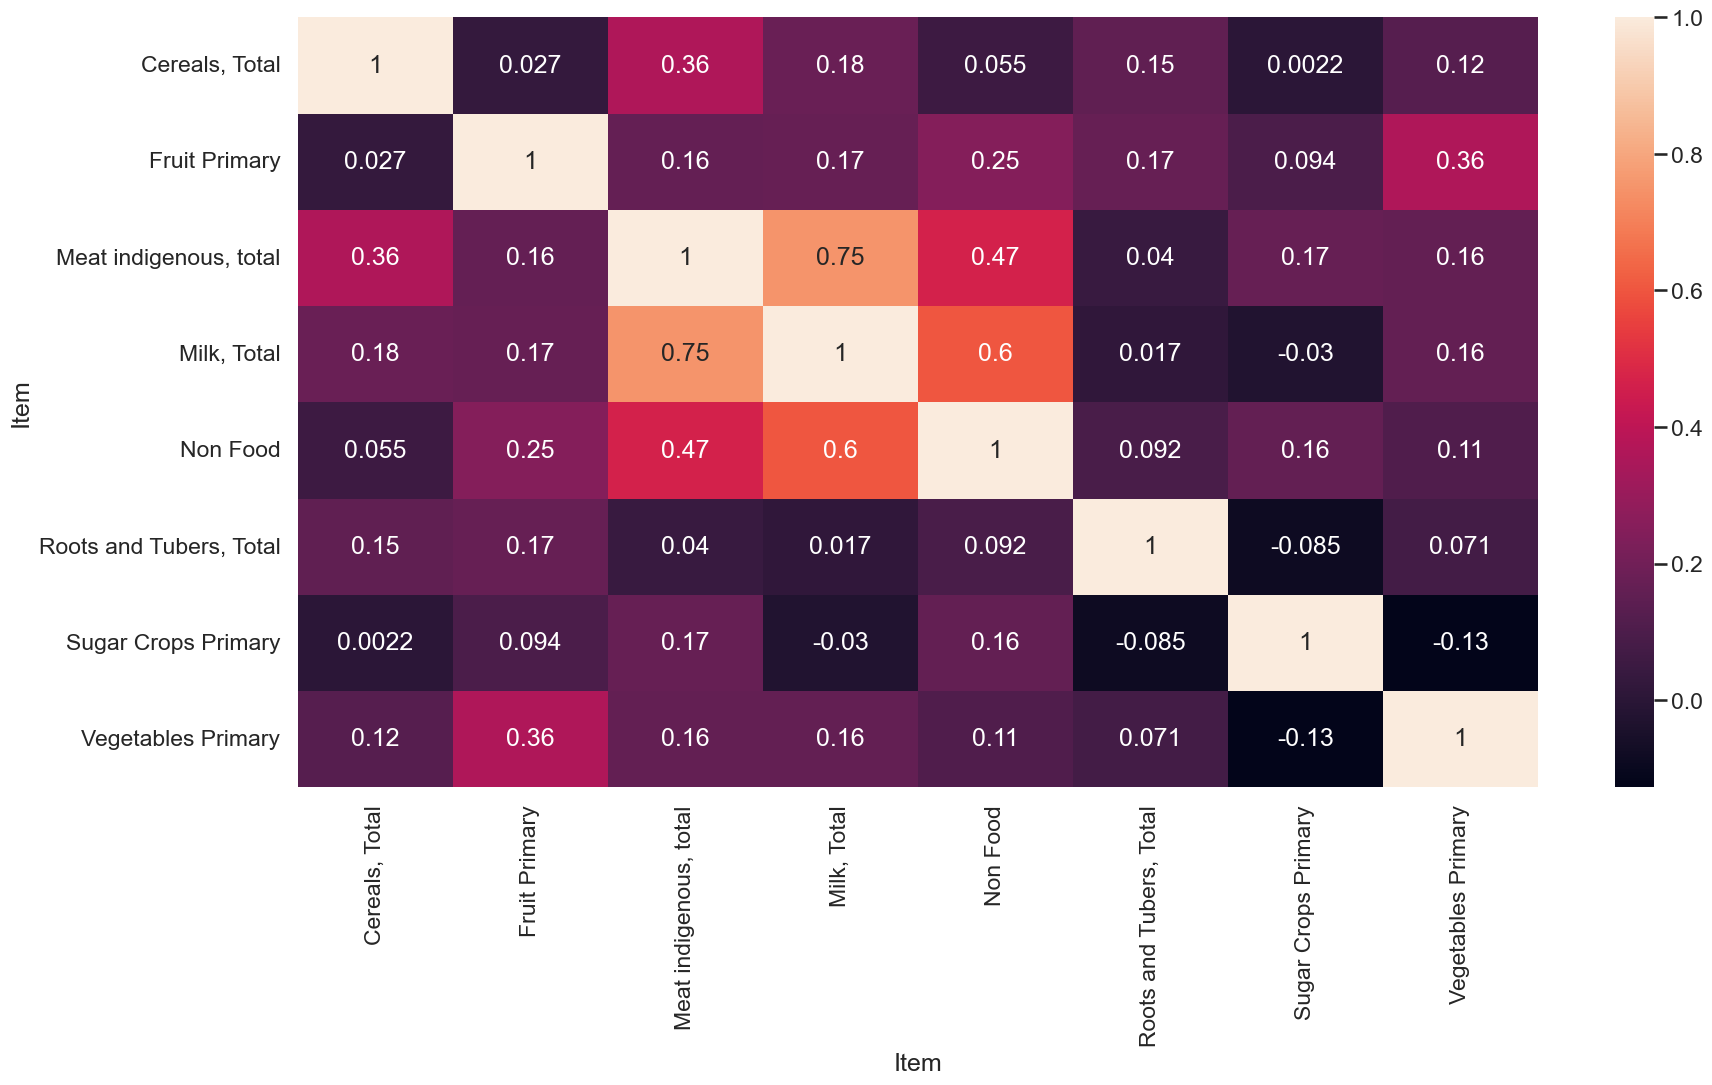

In [24]:
#plotting the correlation matrix
%matplotlib inline
plt.figure(figsize = (20,10))
sns.heatmap(prod_df.corr(),annot = True)
plt.show()

In [25]:
#featurewiz does not work for clustering or unsupervised problems
#pip install featurewiz --user

In [26]:
prod_df.fillna(0, inplace=True)

In [27]:
prod_df.set_index('Area', inplace=True)
prod_df.head()

Item,"Cereals, Total",Fruit Primary,"Meat indigenous, total","Milk, Total",Non Food,"Roots and Tubers, Total",Sugar Crops Primary,Vegetables Primary
Area,,,,,,,,
Afghanistan,36.263282,49.876860,30.440250,24.313719,2.170455,6.103549,0.054991,12.133944
Albania,49.112995,155.545650,96.876247,167.844690,17.509759,22.699254,0.503500,151.655095
Algeria,29.452386,85.487778,64.256817,35.373773,3.959409,29.420493,0.000000,73.969390
Angola,18.371780,57.580569,30.352553,2.807108,1.636325,54.670691,1.040472,6.316054
Antigua and Barbuda,0.108558,58.306284,4.505140,13.808526,0.000000,1.107287,0.000000,6.622013


In [28]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns # data visualization library  
import os
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV

import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [29]:
#https://www.kaggle.com/code/emilytries/clustering-and-feature-selection
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit
    
for col in prod_df.columns:
    replace_with_thresholds(prod_df, col)

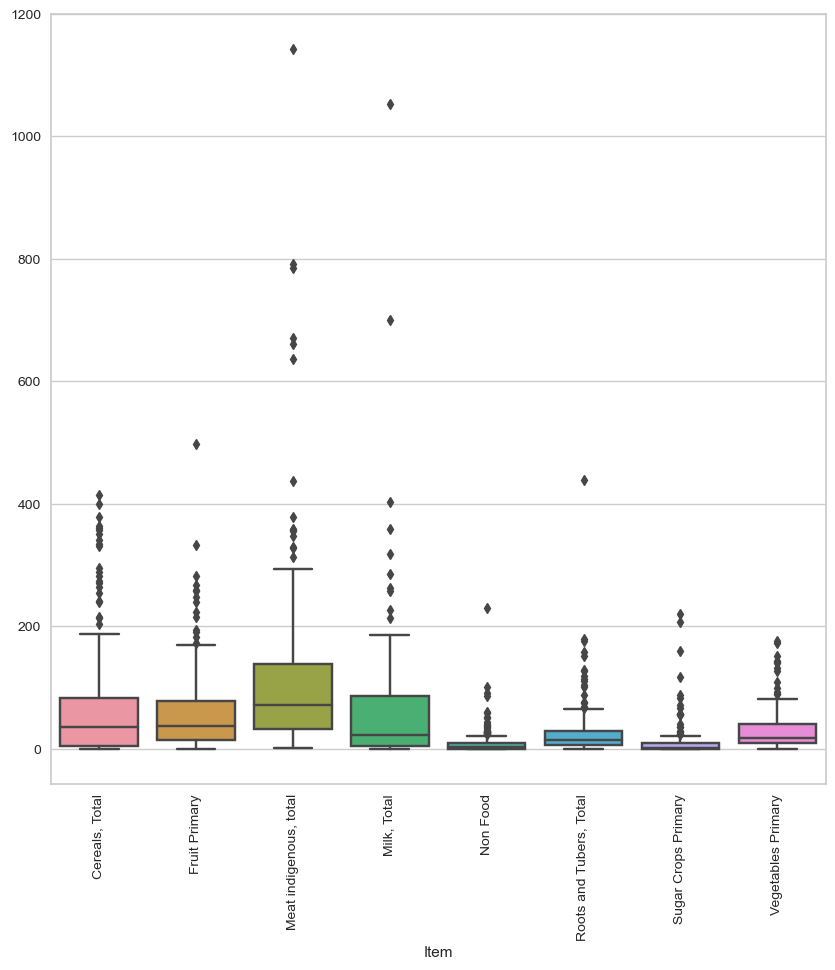

In [30]:
plt.figure(figsize=(10,10))
sns.boxplot(data=prod_df)
plt.xticks(rotation=90)
plt.show()

In [31]:
# Min Max Scaler
names = prod_df.columns
indexes = prod_df.index
sc = MinMaxScaler((0, 1))
df = sc.fit_transform(prod_df)
data_scaled = pd.DataFrame(df, columns=names, index=indexes)
data_scaled.head()

Item,"Cereals, Total",Fruit Primary,"Meat indigenous, total","Milk, Total",Non Food,"Roots and Tubers, Total",Sugar Crops Primary,Vegetables Primary
Area,,,,,,,,
Afghanistan,0.087325,0.100151,0.025753,0.023100,0.009416,0.013908,0.000250,0.068742
Albania,0.118268,0.312330,0.083923,0.159464,0.075962,0.051724,0.002287,0.859169
Algeria,0.070924,0.171657,0.055362,0.033608,0.017177,0.067039,0.000000,0.419057
Angola,0.044241,0.115620,0.025677,0.002667,0.007099,0.124576,0.004726,0.035782
Antigua and Barbuda,0.000261,0.117077,0.003045,0.013119,0.000000,0.002523,0.000000,0.037516


C:\Users\blancc2\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


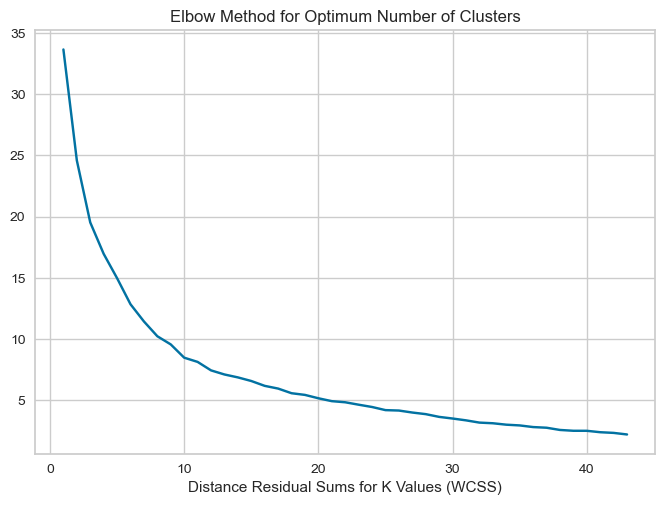

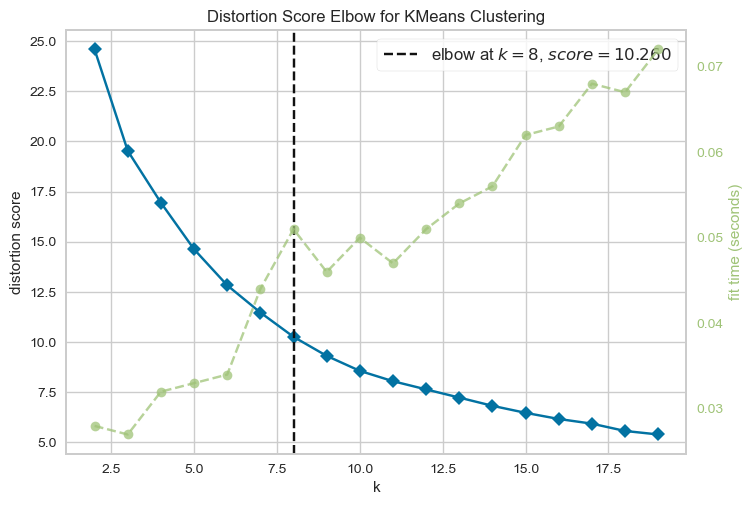

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [32]:
# KMeans Clustering
#https://www.scikit-yb.org/en/latest/api/cluster/elbow.html
kmeans = KMeans()
ssd = []
K = range(1, 44)

for k in K:
    kmeans = KMeans(n_clusters=k).fit(data_scaled)
    ssd.append(kmeans.inertia_)

ssd

plt.plot(K, ssd, "bx-")
plt.xlabel("Distance Residual Sums for K Values (WCSS)")
plt.title("Elbow Method for Optimum Number of Clusters")
plt.show()

kmeans = KMeans()
visu = KElbowVisualizer(kmeans, k=(2, 20))
visu.fit(df)
visu.show()

In [33]:
kmeans = KMeans(n_clusters=8).fit(data_scaled)
clusters = kmeans.labels_

pd.DataFrame({"Customers": prod_df.index, "Clusters": clusters})
prod_df["cluster_no"] = clusters
prod_df.head()

Item,"Cereals, Total",Fruit Primary,"Meat indigenous, total","Milk, Total",Non Food,"Roots and Tubers, Total",Sugar Crops Primary,Vegetables Primary,cluster_no
Area,,,,,,,,,
Afghanistan,36.263282,49.876860,30.440250,24.313719,2.170455,6.103549,0.054991,12.133944,1
Albania,49.112995,155.545650,96.876247,167.844690,17.509759,22.699254,0.503500,151.655095,7
Algeria,29.452386,85.487778,64.256817,35.373773,3.959409,29.420493,0.000000,73.969390,6
Angola,18.371780,57.580569,30.352553,2.807108,1.636325,54.670691,1.040472,6.316054,1
Antigua and Barbuda,0.108558,58.306284,4.505140,13.808526,0.000000,1.107287,0.000000,6.622013,1


In [34]:
prod_df["cluster_no"] = prod_df["cluster_no"] + 1
prod_df.groupby("cluster_no").agg({"cluster_no": "count"})

Item,cluster_no
cluster_no,
1,6
2,100
3,19
4,7
5,1
6,22
7,31
8,9


In [35]:
prod_df.groupby("cluster_no").agg(np.mean)

Item,"Cereals, Total",Fruit Primary,"Meat indigenous, total","Milk, Total",Non Food,"Roots and Tubers, Total",Sugar Crops Primary,Vegetables Primary
cluster_no,,,,,,,,
1,14.534884,290.808019,104.531590,39.502261,9.239634,113.168128,10.318075,28.182734
2,20.770883,33.046655,61.950176,26.881419,6.427849,19.814611,4.336726,12.502099
3,318.076626,77.864587,271.445856,133.165928,10.443729,35.460088,15.618592,32.057241
4,55.891373,78.594452,132.581279,16.498715,28.013893,20.831912,135.274529,15.501654
5,43.675442,258.049854,1143.134127,1052.555603,230.506524,26.762470,0.000000,70.813388
6,148.185682,30.385135,186.445281,120.379941,12.469440,33.995180,8.454776,30.508821
7,42.424810,82.028998,102.093436,51.026408,8.047561,26.074188,6.066105,60.501697
8,71.732759,124.587464,152.576201,113.349199,12.281308,27.575177,4.397956,143.832514


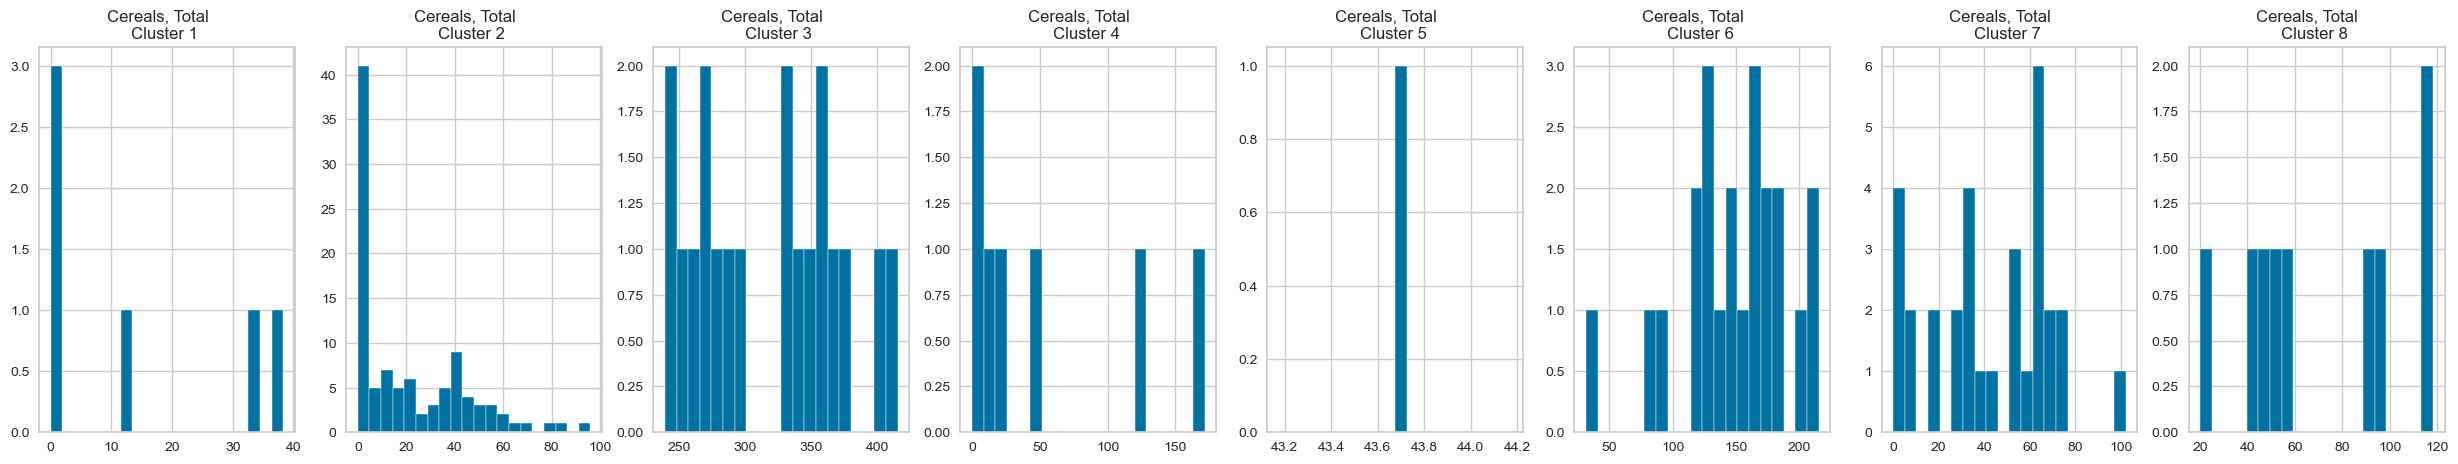

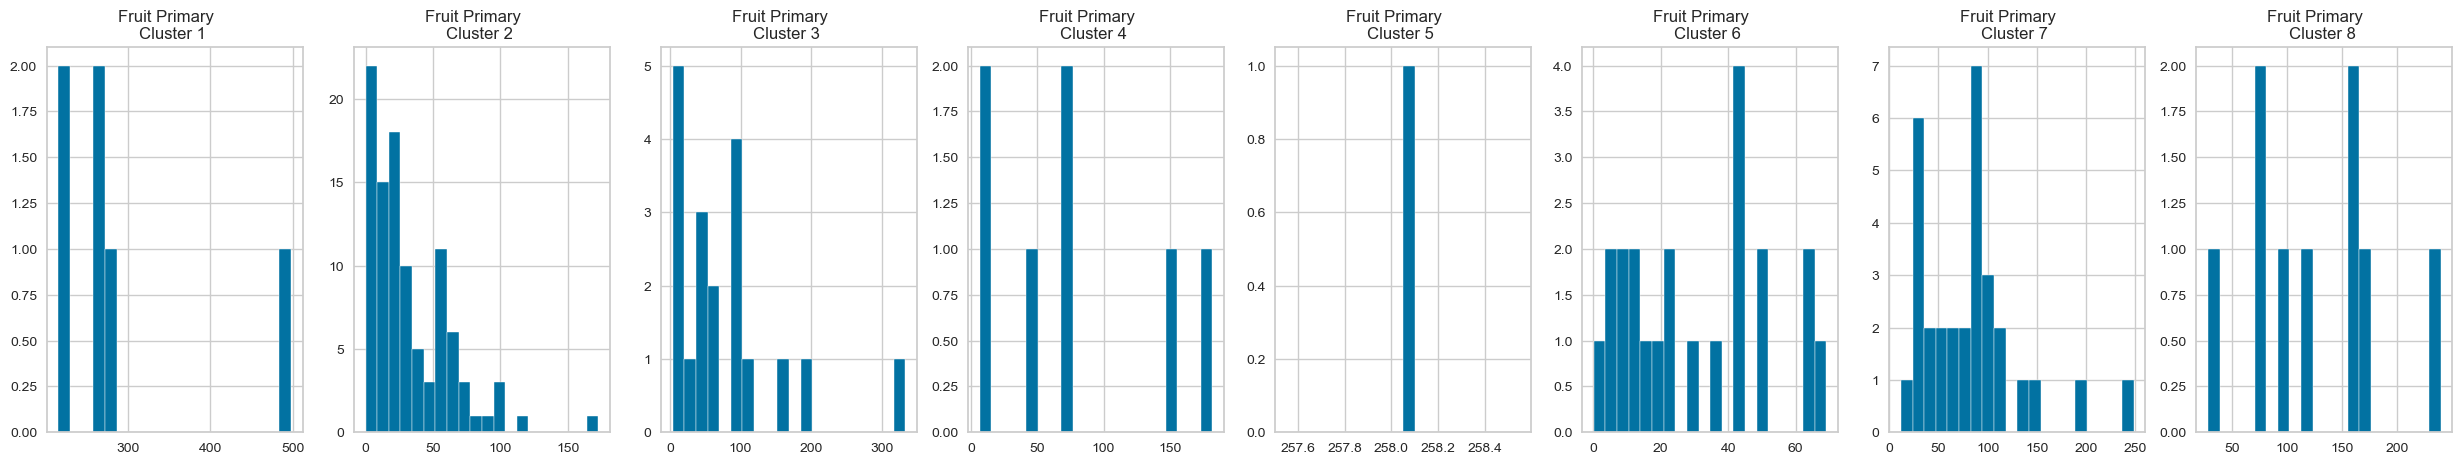

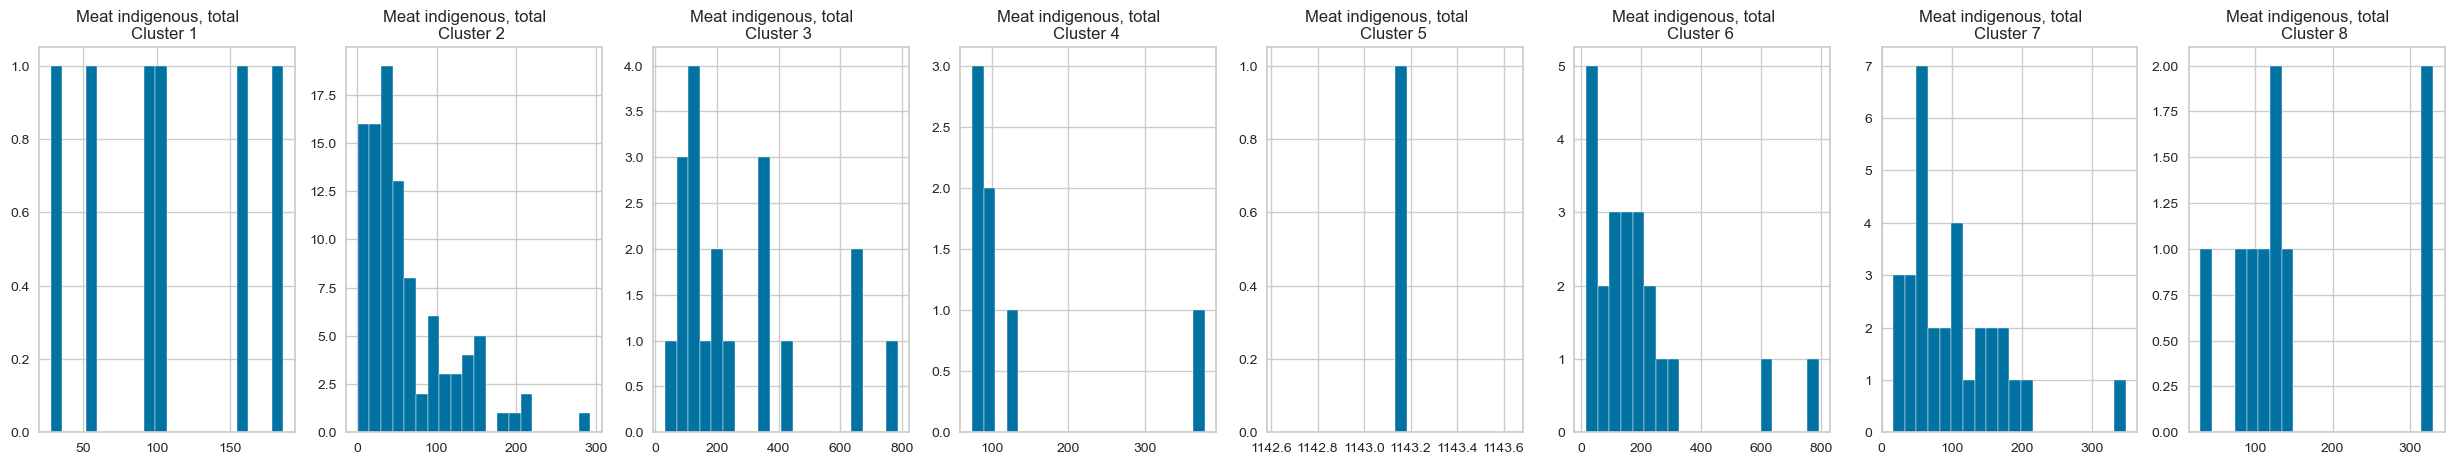

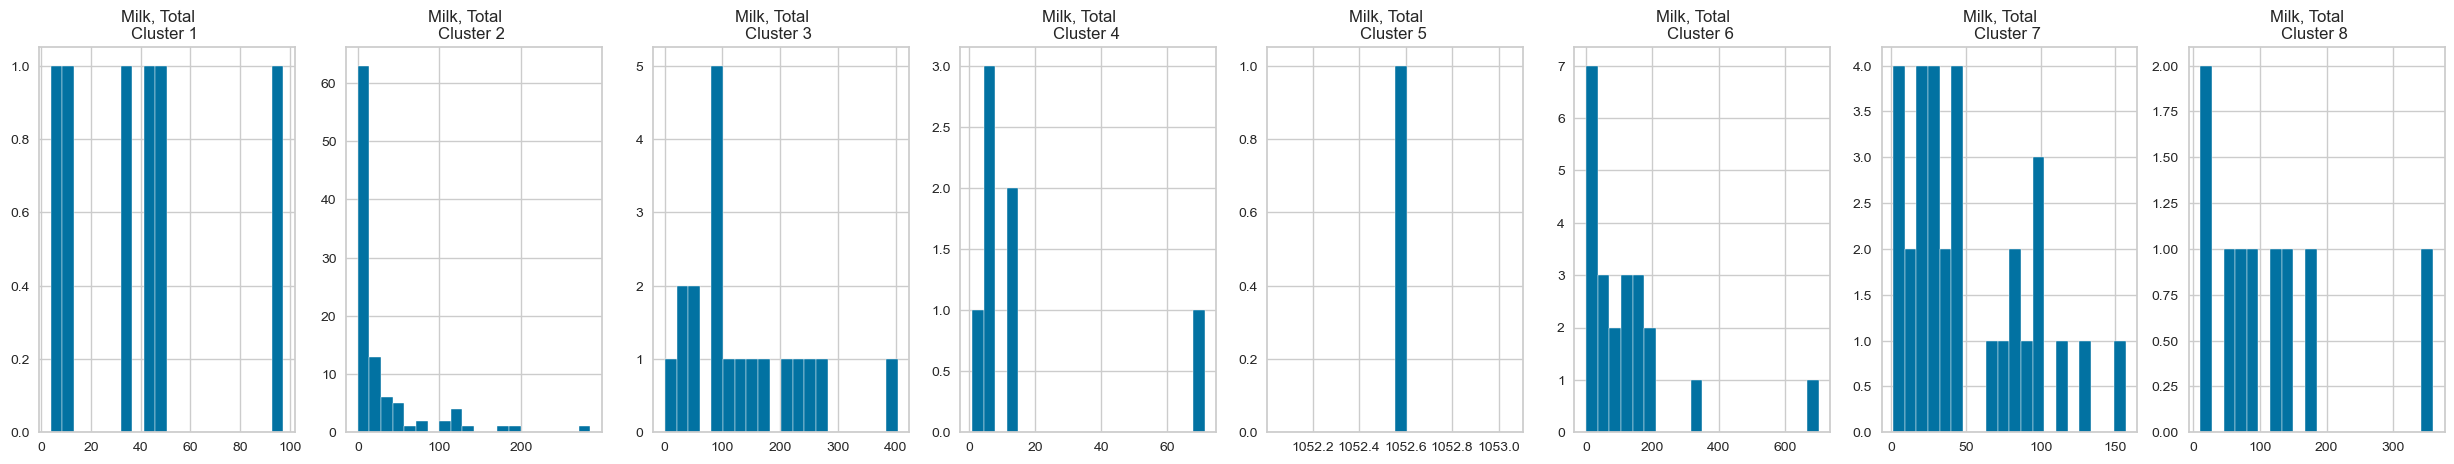

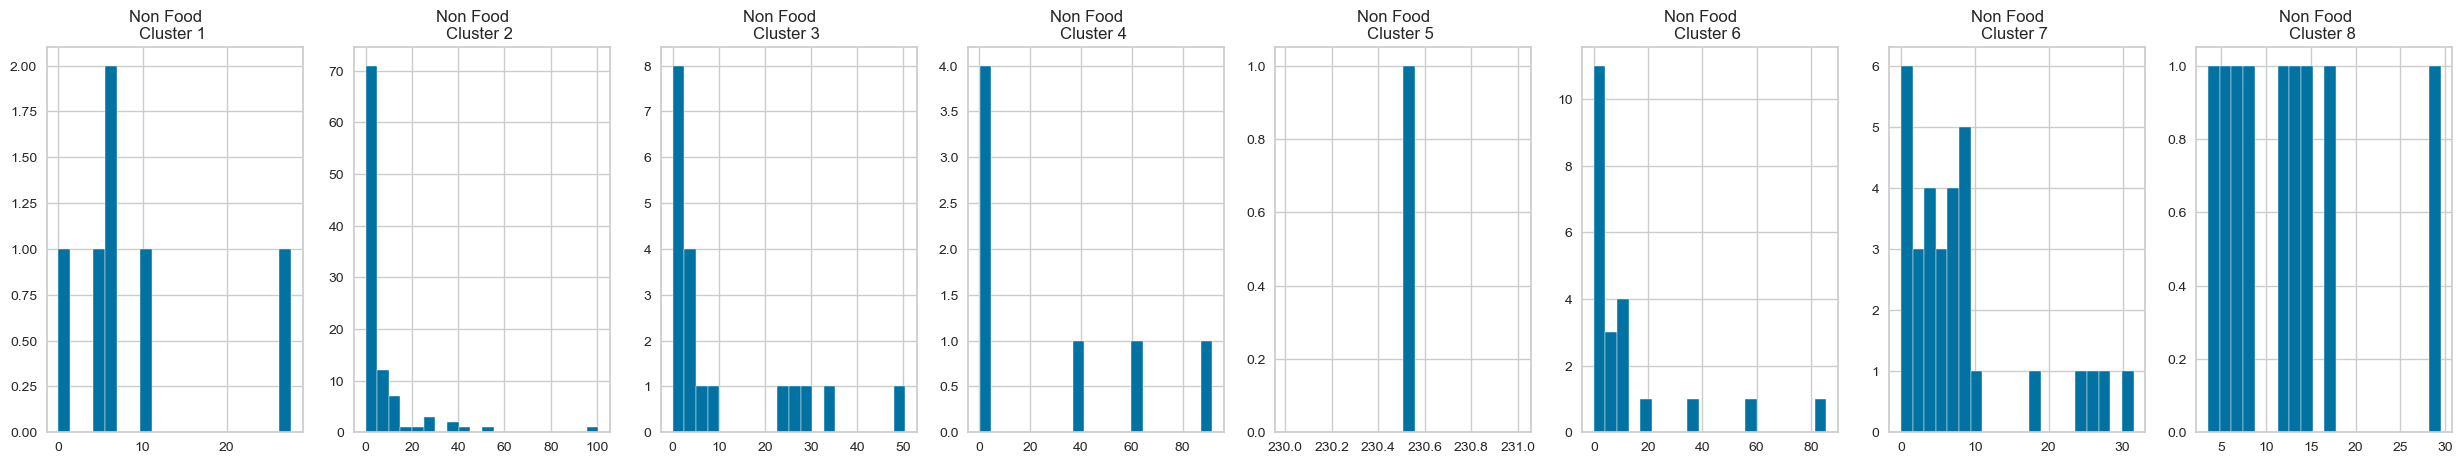

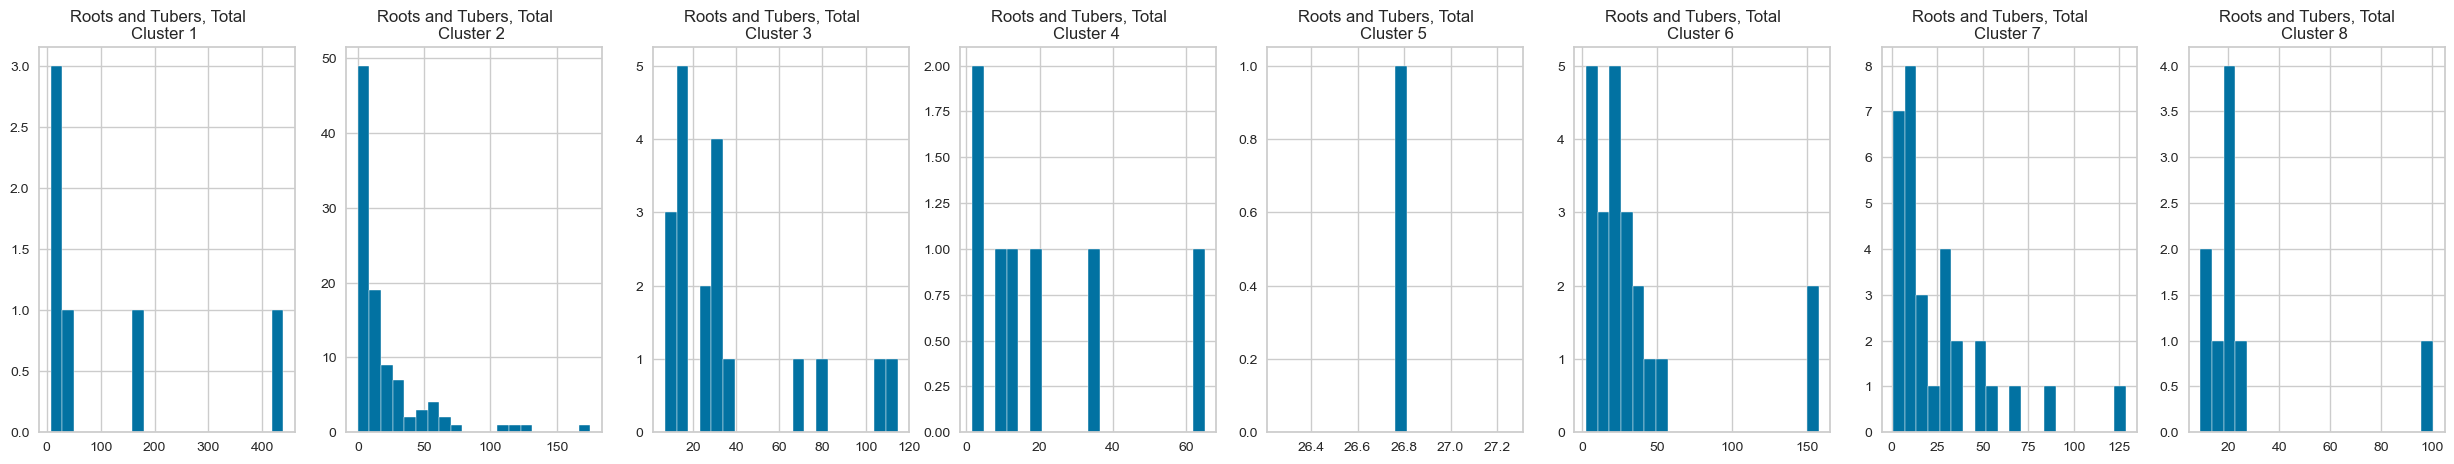

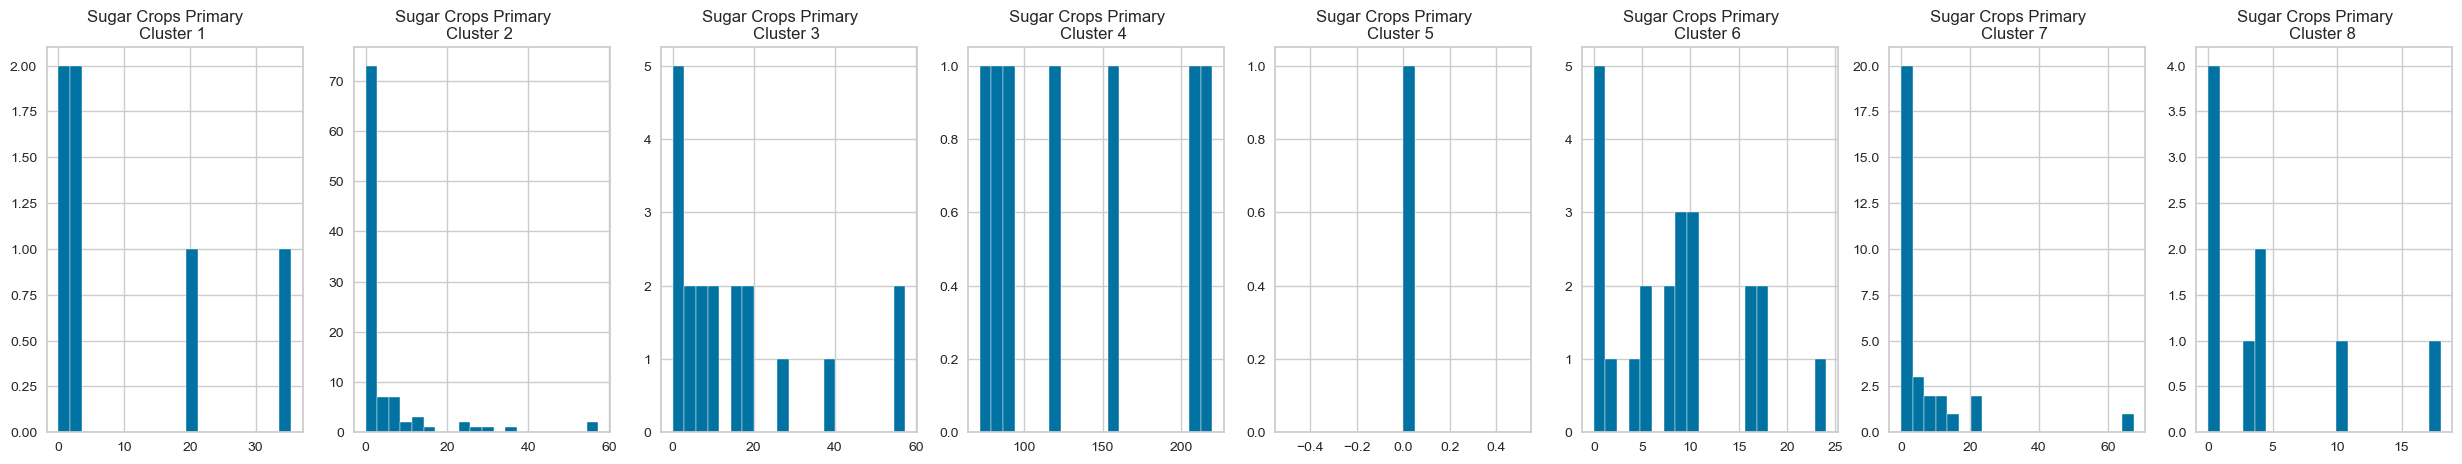

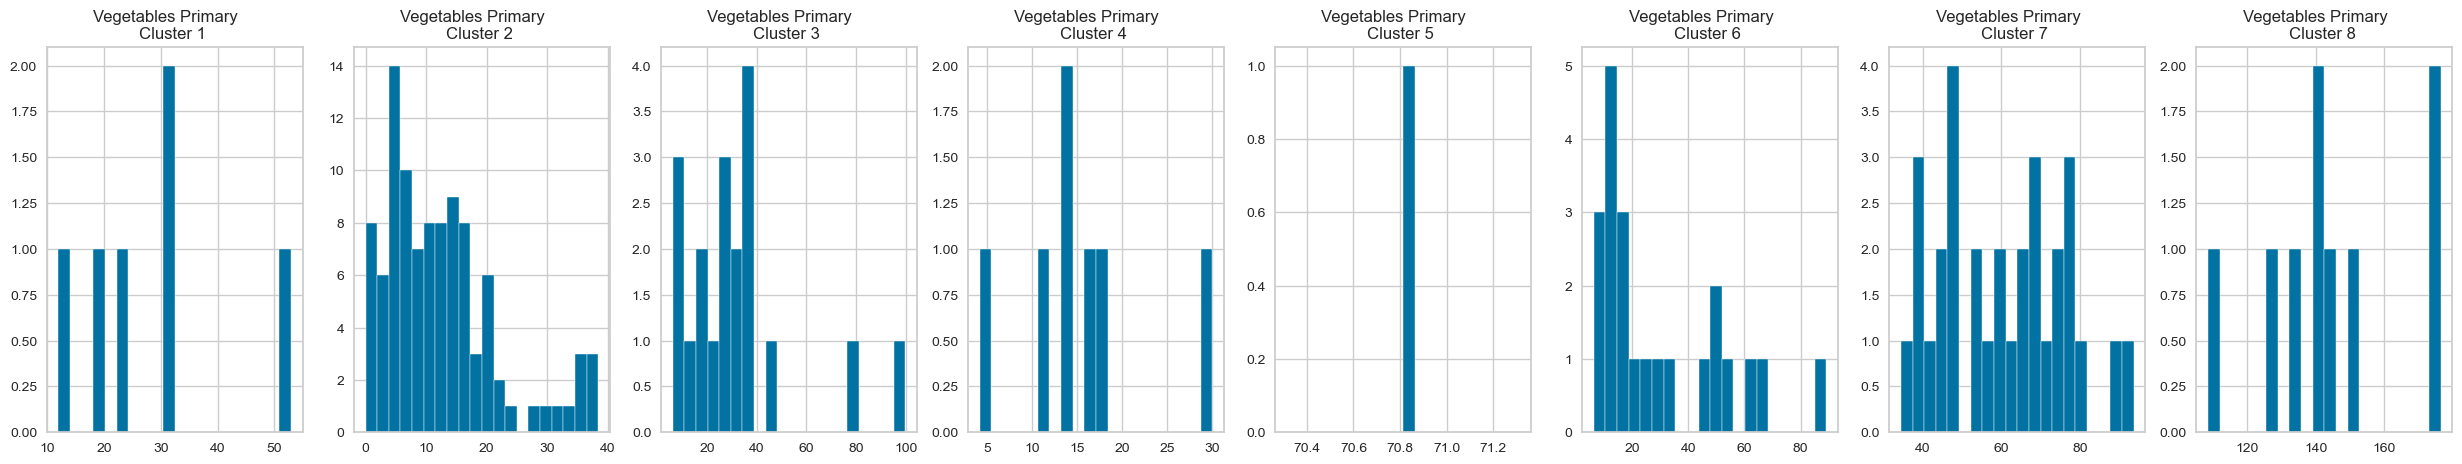

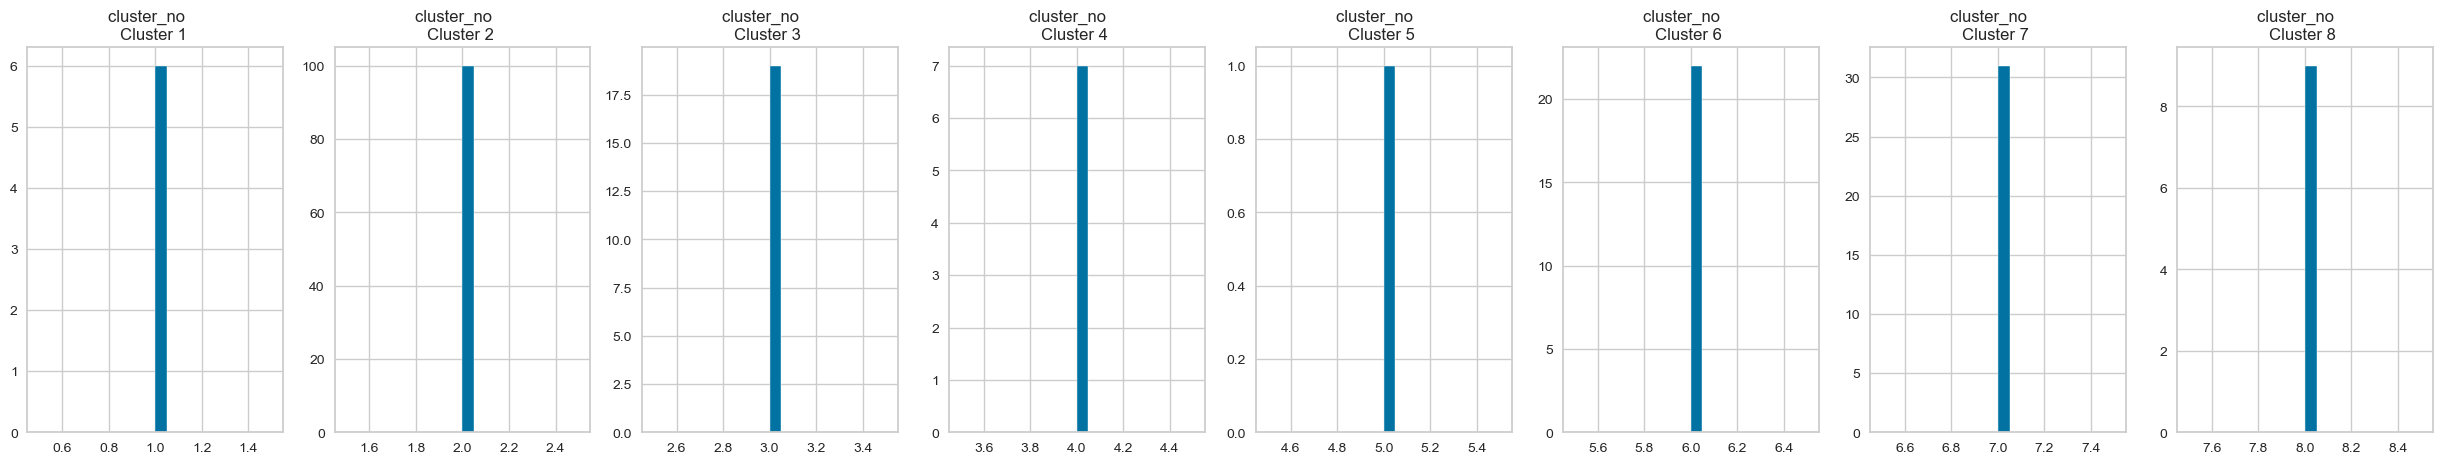

In [36]:
for i in prod_df.columns:
  plt.figure(figsize = (35, 5))
  for j in range(1,9):
    plt.subplot(1,9,j+1)
    cluster = prod_df[prod_df['cluster_no'] == j]
    cluster[i].hist(bins = 20)
    plt.title('{}    \nCluster {} '.format(i,j))
  
  plt.show()

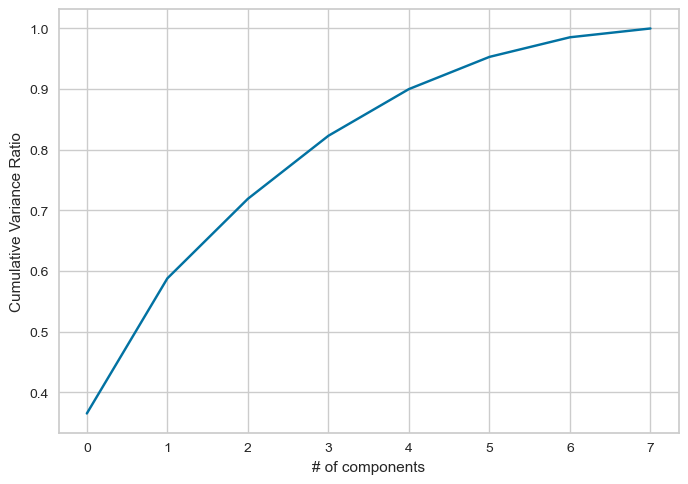

In [37]:
pca = PCA().fit(data_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("# of components")
plt.ylabel("Cumulative Variance Ratio")
plt.show()

In [38]:
for i in range(prod_df.shape[1]-1):
    pca = PCA(n_components=i)
    pca_fit = pca.fit_transform(data_scaled)
    print(i, pca.explained_variance_ratio_.sum())

0 0.0
1 0.36511656043172747
2 0.5878894816156166
3 0.7191155218650638
4 0.8230408114849458
5 0.900051130035674
6 0.9531340072917729
7 0.9854788342024459


In [39]:
pca = PCA(n_components=5)
pca_fit = pca.fit_transform(data_scaled)
pca.explained_variance_ratio_

array([0.36511656, 0.22277292, 0.13122604, 0.10392529, 0.07701032])

In [40]:
#Only for easy visualization, we pick 2 variables.
pca = PCA(n_components=2)
pca_fit = pca.fit_transform(data_scaled)
pca.explained_variance_ratio_

array([0.36511656, 0.22277292])

In [41]:
# Convert to a data frame
X_reduceddf = pd.DataFrame(pca_fit, index=data_scaled.index, columns=['PC1','PC2'])
X_reduceddf['cluster'] = clusters
X_reduceddf.head()

,PC1,PC2,cluster
Area,,,
Afghanistan,-0.150391,-0.063182,1
Albania,0.237025,0.656380,7
Algeria,-0.017164,0.257296,6
Angola,-0.193450,-0.061033,1
Antigua and Barbuda,-0.242290,-0.046319,1


In [42]:
#https://github.com/OpenClassrooms-Student-Center/Multivariate-Exploratory-Analysis/blob/master/functions.py
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    '''Display a scatter plot on a factorial plane, one for each factorial plane'''

    # For each factorial plane
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # Initialise the matplotlib figure      
            fig = plt.figure(figsize=(7,6))
        
            # Display the points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # Display the labels on the points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # Define the limits of the chart
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # Display grid lines
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # Label the axes, with the percentage of variance explained
            plt.xlabel('PC{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('PC{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection of points (on PC{} and PC{})".format(d1+1, d2+1))
            #plt.show(block=False)
            
def display_parallel_coordinates_centroids(df, num_clusters):
    '''Display a parallel coordinates plot for the centroids in df'''

    # Create the plot
    fig = plt.figure(figsize=(12, 5))
    title = fig.suptitle("Parallel Coordinates plot for the Centroids", fontsize=18)
    fig.subplots_adjust(top=0.9, wspace=0)

    # Draw the chart
    parallel_coordinates(df, 'cluster', color=palette)

    # Stagger the axes
    ax=plt.gca()
    for tick in ax.xaxis.get_major_ticks()[1::2]:
        tick.set_pad(20)    

C:\Users\blancc2\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


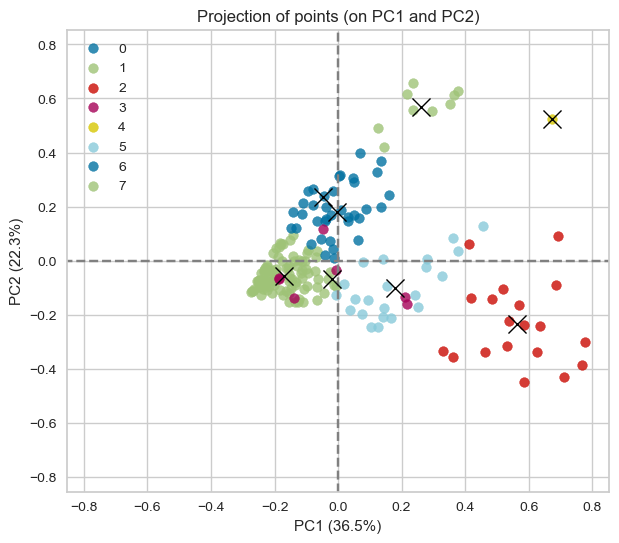

In [43]:
from sklearn.decomposition import PCA
centres_reduced = pca.transform(kmeans.cluster_centers_)
display_factorial_planes(pca_fit, 2, pca, [(0,1)], illustrative_var = clusters, alpha = 0.8)
plt.scatter(centres_reduced[:, 0], centres_reduced[:, 1],
            marker='x', s=169, linewidths=1,
            color='black', zorder=10)

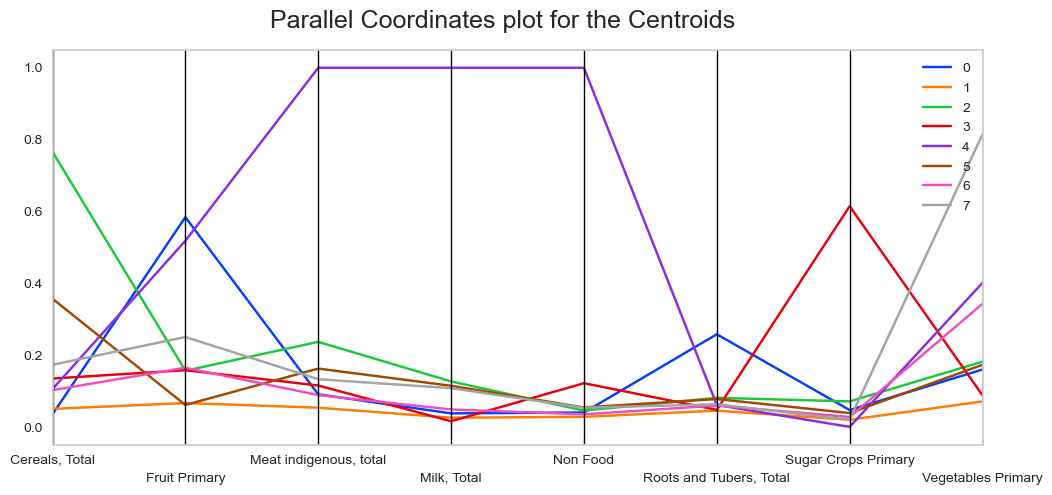

In [44]:
from pandas.plotting import parallel_coordinates
palette = sns.color_palette("bright", 10)


# Add the cluster number to the original scaled data
X_clustered = pd.DataFrame(data_scaled, index=data_scaled.index, columns=data_scaled.columns)
X_clustered["cluster"] = clusters
means =  X_clustered.groupby(by="cluster").mean()
display_parallel_coordinates_centroids(means.reset_index(), 5)

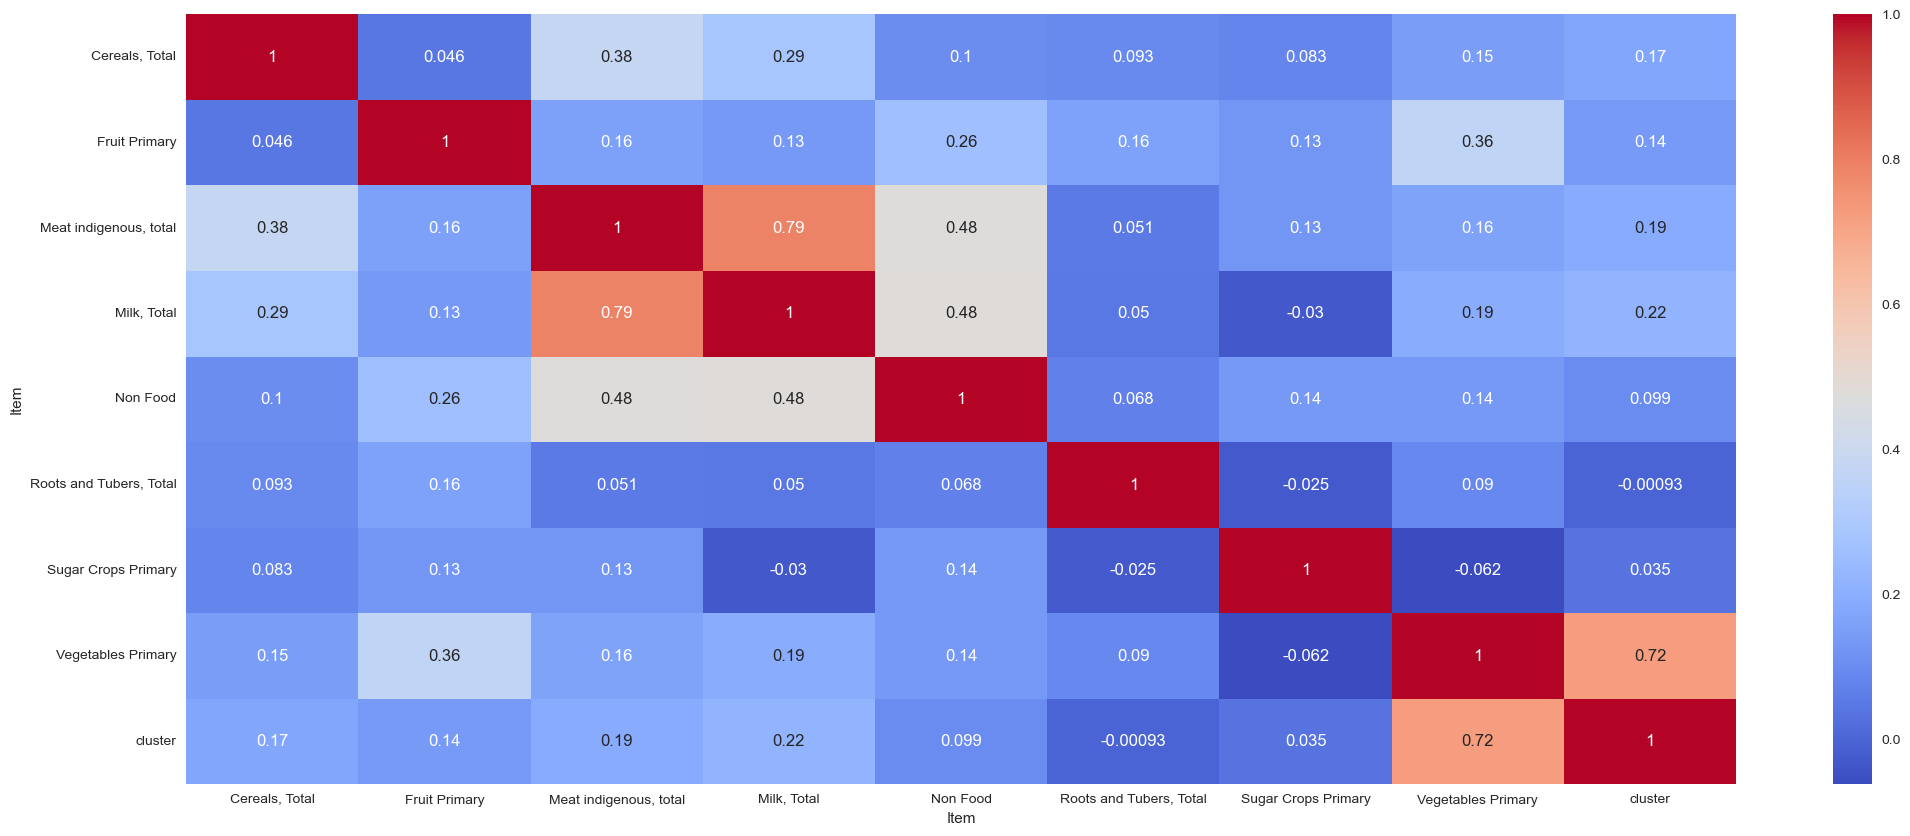

In [45]:
plt.figure(figsize=(25,10))
cor = data_scaled.corr()
sns.heatmap(cor, annot=True, cmap='coolwarm')
plt.show()

In [46]:
def get_redundant_pairs(df):
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(data_scaled, 5))

Top Absolute Correlations
Item                    Item                  
Meat indigenous, total  Milk, Total               0.790195
Vegetables Primary      cluster                   0.722327
Milk, Total             Non Food                  0.477975
Meat indigenous, total  Non Food                  0.477293
Cereals, Total          Meat indigenous, total    0.380859
dtype: float64


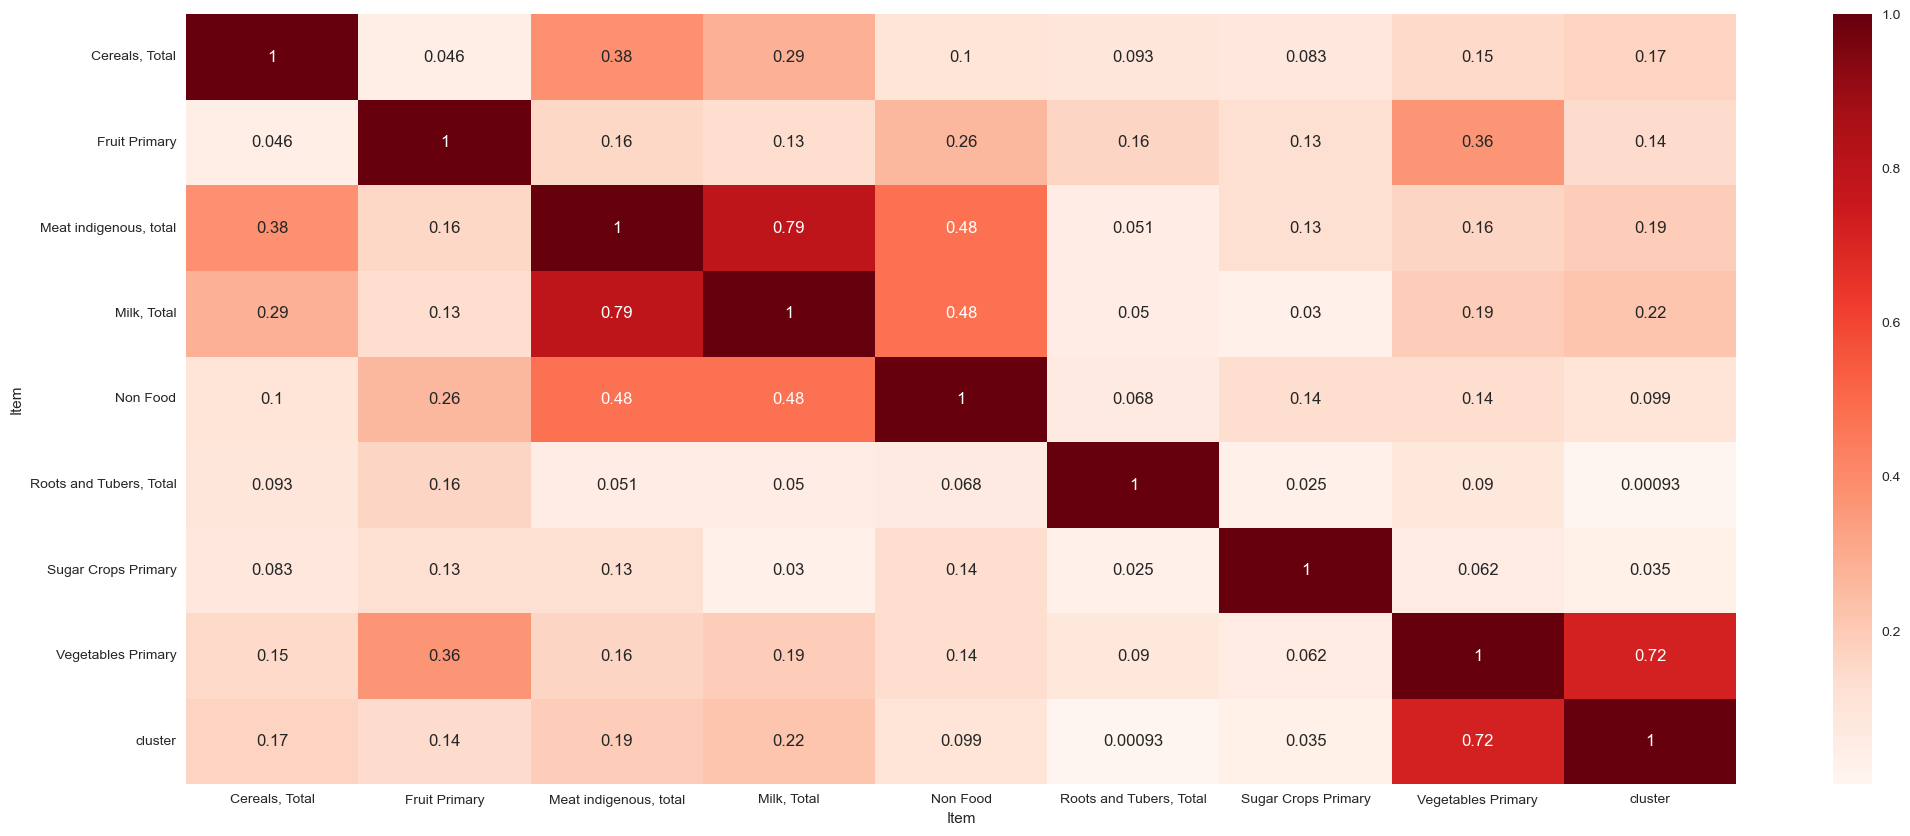

In [47]:
plt.figure(figsize=(25,10))
cor = data_scaled.corr().abs()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [48]:
codes_df = pd.read_csv(pop_folder /"Population_E_AreaCodes.csv", encoding = 'unicode_escape')

In [49]:
prod_df=prod_df.merge(codes_df, on='Area')

In [50]:
import country_converter as coco
cc = coco.CountryConverter()
prod_df['iso']=cc.pandas_convert(prod_df['Area'], to='ISO3')

In [51]:
pd.set_option('display.max_rows', None)

In [52]:
import plotly.express as px

In [56]:
fig = px.choropleth(prod_df, 
                    locations=prod_df['iso'], 
                    color="cluster_no",
                     hover_name="cluster_no",
                    labels={'cluster_no':'Cluster'},
                    title='foo',
                    color_continuous_scale=px.colors.sequential.Plasma,
                   )
fig.update_geos(fitbounds="locations", visible=True)
fig.update_layout(title_text='Map of countries by cluster',title_x = 0.4, title_y=0.9,margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [54]:

cluster_ire=prod_df['cluster_no'][prod_df['Area']=='Ireland'].values[0]
print("Regions in the same cluster than Ireland: \n")
#use to_string function to remove the "Name", "Dtype" from the output. 
print(prod_df['Area'][prod_df['cluster_no']==cluster_ire].to_string(index=False))

Regions in the same cluster than Ireland: 

                                           Austria
                                        Bangladesh
                                           Belarus
                                           Croatia
                                           Czechia
                                           Finland
                                           Germany
                                            Guinea
                                           Ireland
                                        Kazakhstan
                  Lao People's Democratic Republic
                                              Mali
                                          Mongolia
                                           Myanmar
                                             Nepal
                                            Poland
                                Russian Federation
                                          Slovakia
                                      

In [55]:
prod_df[prod_df['cluster_no']==cluster_ire]

,Area,"Cereals, Total",Fruit Primary,"Meat indigenous, total","Milk, Total",Non Food,"Roots and Tubers, Total",Sugar Crops Primary,Vegetables Primary,cluster_no,Area Code,M49 Code,iso
8,Austria,129.367090,51.851814,244.388476,179.420920,1.280076,21.173229,10.425859,23.984622,6,11,'040,AUT
12,Bangladesh,134.773630,14.964878,16.057212,9.966002,7.549592,14.893519,0.906715,14.477892,6,16,'050,BGD
14,Belarus,156.858130,37.247579,312.594900,318.123964,9.408132,157.946101,24.083285,67.084551,6,57,'112,BLR
40,Croatia,176.956147,43.789797,124.603124,62.397209,4.544099,10.493124,8.083294,12.333186,6,98,'191,HRV
43,Czechia,161.736440,12.421429,104.916441,125.320221,0.075354,14.787882,16.370515,6.474598,6,167,'203,CZE
60,Finland,146.348924,7.382727,179.401859,178.952708,0.155210,28.052334,4.278157,17.558155,6,67,'246,FIN
66,Germany,118.468950,22.799620,195.163185,165.699952,1.027203,31.911754,16.843900,16.112603,6,79,'276,DEU
71,Guinea,129.679669,43.431125,47.321154,9.391701,11.073933,38.969868,1.094308,16.459667,6,90,'324,GIN
82,Ireland,94.283744,4.168693,791.689942,700.796913,11.969521,19.545472,0.000000,22.905753,6,104,'372,IRL
88,Kazakhstan,215.732022,50.821739,214.422133,130.310514,35.183477,52.205638,1.219563,89.152874,6,108,'398,KAZ
